# CNN Cancer Detection Project



In this project, I will create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans with the help of a CNN model. I will start with EDA, then split the data in train and test samples, define the model, fit it and test its accuracy.


In this notebook, we will be using the data available at https://www.kaggle.com/c/histopathologic-cancer-detection/overview

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
 
import warnings

# Exploratory Data Analysis

In this section, we will analyse the data in order to prepare it for use in the model.

By showing a couple values of the 'train_labels.csv' file, we can see that it stores the name of each image and its belonging to non-cancerous (0) or cancerous (1) category.

In [3]:
test_path = 'data/histopathologic-cancer-detection/test/'
train_path = 'data/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('data/histopathologic-cancer-detection/sample_submission.csv')
train_data = pd.read_csv('data/histopathologic-cancer-detection/train_labels.csv')
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In this next cell, we display a couple images.  It is clear that if you are not a medical expert, it is impossible for you to tell if the cells are cancerous or not.

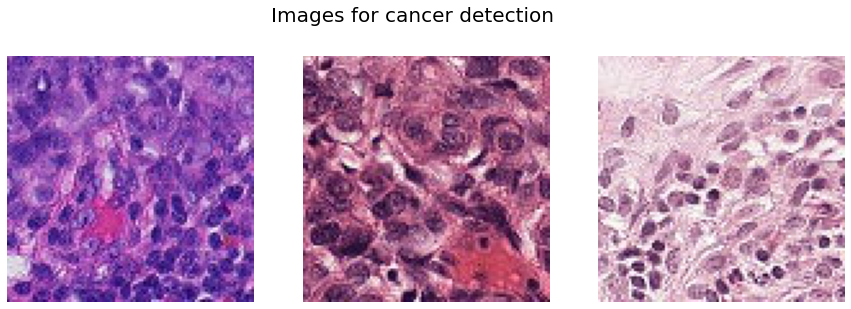

In [4]:
path = 'data/histopathologic-cancer-detection/train'

image_dir = f'{path}'
images = os.listdir(image_dir)
 
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f'Images for cancer detection', fontsize=20)
 
for i in range(3):
    k = np.random.randint(0, len(images))
    img = np.array(Image.open(f'{path}/{images[k]}'))
    ax[i].imshow(img)
    ax[i].axis('off')
plt.show()

### Creating the train and test sets
The following code will divide the train set into 80% of training data and 20% of testing data which is necessary for the model to check its accuracy. We will normalize the images by dividing each pixel by 255 in order to have values between 0 and 1.

In [5]:
im_size = 64
split = 0.2
nepochs = 10
b_size = 64
RANDOM_STATE=2022

In [6]:
def append_tif(string):
    return string+".tif"

train_data["id"] = train_data["id"].apply(append_tif)
train_data['label'] = train_data['label'].astype(str)

# randomly shuffle training data
train_data = shuffle(train_data, random_state=RANDOM_STATE)

In [7]:
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.20)



In [8]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=b_size,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(im_size,im_size))


Found 176020 validated image filenames belonging to 2 classes.


In [9]:
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=b_size,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(im_size,im_size))

Found 44005 validated image filenames belonging to 2 classes.


# Model building and fitting

In this section, we will create the model and fit it to the training data. We will then predict if an image shows cancerous cells or not and compare those results to the testing data.

### Model building

To build the model, I have chosen the following architecture : input --> Conv2D (32 filters and ReLu activation function) --> MaxPool  --> Conv2D (64 filters and ReLu activation function)  --> MaxPool --> Conv2D (64 filters and ReLu activation function) --> MaxPool --> Flatten --> Output with sigmoid activation

In [10]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(3, 3),
                  activation='relu',
                  input_shape=(im_size,
                               im_size,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

we use adaptive moment estimation (Adam) with a learning rate of 0.001 for optimizing the model which essentially mimics momentum for gradient adn gradient-squared.

In [15]:
adam_optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = adam_optimizer,
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

#### Callbacks
Callbacks are used to check whether the model is improving with each epoch or not. If not, ReduceLROnPlateau allows to decrease the learning rate further. If the model performance is still not improving, then training will be stopped by EarlyStopping. We can also define some custom callbacks to stop training in between if the desired results have been obtained early.

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [17]:
history = model.fit_generator(train_generator,
                    validation_data = valid_generator,
                    epochs = nepochs,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/10
2751/2751 [==============================] - 1136s 412ms/step - loss: 0.3023 - accuracy: 0.8752 - val_loss: 0.4198 - val_accuracy: 0.8142
Epoch 2/10
2751/2751 [==============================] - 986s 358ms/step - loss: 0.2754 - accuracy: 0.8869 - val_loss: 0.2899 - val_accuracy: 0.8816
Epoch 3/10
2751/2751 [==============================] - 961s 349ms/step - loss: 0.2533 - accuracy: 0.8978 - val_loss: 0.3526 - val_accuracy: 0.8656
Epoch 4/10
2751/2751 [==============================] - 1110s 404ms/step - loss: 0.2348 - accuracy: 0.9055 - val_loss: 0.3426 - val_accuracy: 0.8710

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/10
2751/2751 [==============================] - 1118s 406ms/step - loss: 0.1919 - accuracy: 0.9249 - val_loss: 0.2313 - val_accuracy: 0.9089

 Validation accuracy has reached upto                       90% so, stopping further training.


We can visualize the evolution of loss and accuracy for each epoch.

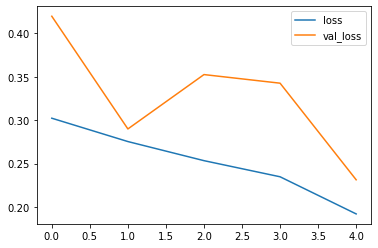

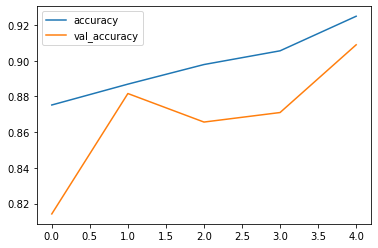

In [18]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

## Testing the model with the submission test sample
Now that we have a trained model, we can test it on the unseen test data images. We must also normalize the test data like we did with the training data. Then we run the model to find its predictions, save it and upload it to kaggle. (Update : after Kaggle submission, my model has a 0.80 private score and a 0.84 public score).

In [19]:
test_df = pd.DataFrame({'id':os.listdir(test_path)})
test_df.head()

,id
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif
2,19709bec800f372d0b1d085da6933dd3ef108846.tif
3,7a34fc34523063f13f0617f7518a0330f6187bd3.tif
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif


In [20]:
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(im_size,im_size),         # original image = (96, 96) 
    batch_size=1,
    shuffle=False,
    class_mode=None)


Found 57458 validated image filenames.


In [21]:
prediction = model.predict(test_generator, verbose=1)

57458/57458 [==============================] - 268s 5ms/step


In [22]:
predictions = np.transpose(prediction)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, prediction))
submission_df.head()

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,0
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0
2,19709bec800f372d0b1d085da6933dd3ef108846,1
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0


In [23]:
submission_df.to_csv('submission1.csv', index=False)

## Conclusion
Through this project, I was able to design a CNN model capable of analysing images in order to identify metastatic cancer. My model achieved a 0.8 accuracy with the Kaggle test data. I could attempt to improve it by changing the structure of my model and testing the influence of different learning rates but I am limited in computational power so those improvements would take a long time.